# HuggingFace로 두 문장의 논리적 모순 분류하기

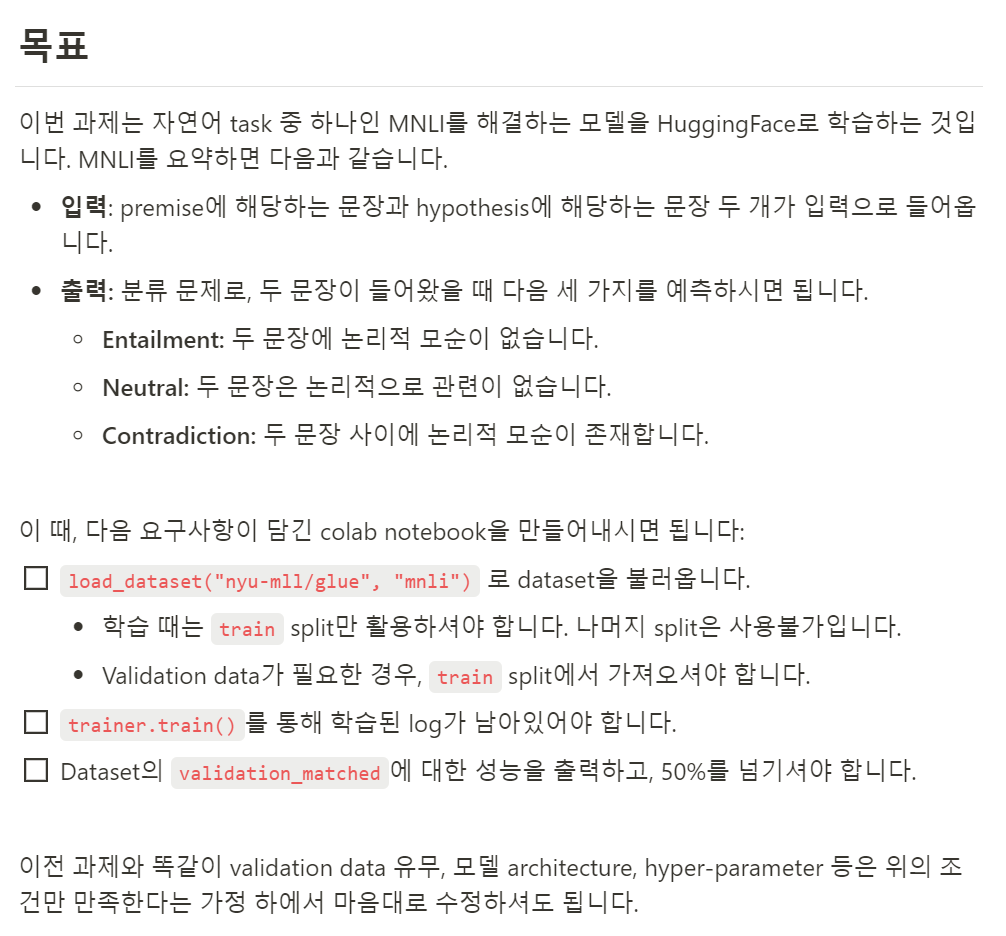

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn sacrebleu sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00


In [2]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer

## Dataset 준비

In [3]:
# 1. 데이터 불러오기
mnli=load_dataset("nyu-mll/glue", "mnli")
mnli

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [ ]:
set(mnli['train']['label'])

{0, 1, 2}

In [ ]:
mnli['validation_matched'][0]

{'premise': 'The new rights are nice enough',
 'hypothesis': 'Everyone really likes the newest benefits ',
 'label': 1,
 'idx': 0}

In [ ]:
set(mnli['validation_matched']['label'])

{0, 1, 2}

In [4]:
# 2. 토크나이징
# premise, hypothesis랑 둘다를 토크나이징 시켜야겠지?
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(data):
  return tokenizer(
      data['premise'],
      data['hypothesis'],
      padding="max_length",
      truncation=True
  )

mnli_tokenized = mnli.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [5]:
mnli_tokenized

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [6]:
# train 데ㅣ터를 train 데이터와 validation 데이터로 나누기
mnli_split = mnli_tokenized['train'].train_test_split(test_size=0.2)
mnli_train, mnli_val = mnli_split['train'], mnli_split['test']

# test 데이터 (이건 어디다가 쓰지??)
mnli_test = mnli_tokenized['validation_matched']


In [7]:
mnli_split

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 314161
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 78541
    })
})

## Model 구현

In [8]:
#from_config를 쓸까, from_pretrained를 쓸까

from transformers import AutoModelForSequenceClassification, Trainer, TFTrainingArguments

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 학습 코드

In [12]:
from transformers import Trainer, TrainingArguments
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # 결과 저장 위치
    evaluation_strategy="epoch",     # 평가 전략 (매 epoch마다 평가)
    per_device_train_batch_size=16,  # 배치 크기
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # 학습 epoch 수
    weight_decay=0.01,               # 가중치 감쇠
)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mnli_train,  # 학습 데이터
    eval_dataset=mnli_val  # 평가 데이터
)

# 모델 학습
trainer.train()


# 디스크용량 부족이라고 자꾸 떠서 완료 못하고 우선 제출합니다 ㅠ

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.save_model()

## 학습모델 결과

In [ ]:
trainer.predict(mnli_tokenized['validation_matched'])